# Emotion Detection Algorithm

In [ ]:
# IMPORT NECESSARY LIBRARIES
import librosa
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio
import numpy as np
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os # interface with underlying OS that python is running on
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from tensorflow.keras import callbacks

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.backend import expand_dims
from sklearn import preprocessing

In [2]:
basedir='/Users/pankajpatel/code/pankaj-lewagon/ser/raw_data/ravdess_data/'

# Data Preprocessing

## Labeling Audio Files

In [3]:
# CREATE DIRECTORY OF AUDIO FILES 
audio=basedir
actor_folders = os.listdir(audio) #list files in audio directory
actor_folders.sort() 
actor_folders[0:5]

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05']

In [4]:
def create_load_radvess(exclude_emotions=[]):
# CREATE FUNCTION TO EXTRACT EMOTION NUMBER, ACTOR AND GENDER LABEL
    
    #emotion_type={1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}
    emotion = []
    gender = []
    actor = []
    file_path = []
    for i in actor_folders:
        filename = os.listdir(audio + i) #iterate over Actor folders
        for f in filename: # go through files in Actor folder
            part = f.split('.')[0].split('-')
            emotion_type=int(part[2])
            if emotion_type not in exclude_emotions :   #  Drop "surprise" emotion
                emotion.append(int(part[2]))
                actor.append(int(part[6]))
                bg = int(part[6])
                if bg%2 == 0:
                    bg = "female"
                else:
                    bg = "male"
                gender.append(bg)
                file_path.append(audio + i + '/' + f)
     # PUT EXTRACTED LABELS WITH FILEPATH INTO DATAFRAME
    audio_df = pd.DataFrame(emotion)
    audio_df = audio_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
    audio_df = pd.concat([pd.DataFrame(gender),audio_df,pd.DataFrame(actor)],axis=1)
    audio_df.columns = ['gender','emotion','actor']
    audio_df = pd.concat([audio_df,pd.DataFrame(file_path, columns = ['path'])],axis=1)               
    return audio_df

## Feature Extraction

### Getting two image from Mel Spec as we are gong to be using Conv 2d in the model later on. 

In [5]:
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [6]:
audio_df=create_load_radvess([8]) 

In [7]:
audio_df.head()

,gender,emotion,actor,path
0,male,angry,1,/Users/pankajpatel/code/pankaj-lewagon/ser/raw...
1,male,fear,1,/Users/pankajpatel/code/pankaj-lewagon/ser/raw...
2,male,fear,1,/Users/pankajpatel/code/pankaj-lewagon/ser/raw...
3,male,angry,1,/Users/pankajpatel/code/pankaj-lewagon/ser/raw...
4,male,disgust,1,/Users/pankajpatel/code/pankaj-lewagon/ser/raw...


In [8]:
def generate_melspec_tensor(df):
    """
        Take data frame with lables and path of all the audio files and convert it to X to tensor compitable numpy.array 
        and  get target classification labels (i.e. emotion)
        
        return X = numpy.array 
               y = series 
    """
    n_melspec=60
    audio_duration=2.5
    sampling_rate_=44100
    input_length= sampling_rate_ * audio_duration
    
    X_melspec = np.empty(shape=(df.shape[0], n_melspec, 216,1))
    for index,path in enumerate(audio_df.path):
        data, _ = librosa.load(path,sr=sampling_rate_,res_type='kaiser_fast',duration=2.5,offset=0.5)

         # Random offset / Padding
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length+offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, int(input_length) - len(data) - offset), "constant")
            
        #get the mel-scaled spectrogram (ransform both the y-axis (frequency) to log scale, 
        melspec = librosa.feature.melspectrogram(data, n_mels = n_melspec)   
        logspec = librosa.amplitude_to_db(melspec)
        logspec = np.expand_dims(logspec, axis=-1)
        X_melspec[index,] = logspec

        y=audio_df['emotion']
    return X_melspec, y

In [9]:
X,y=generate_melspec_tensor(audio_df)

In [10]:
type(y)

pandas.core.series.Series

In [11]:
type(X)

numpy.ndarray

In [12]:
y.shape

(1248,)

# Data Preprocessing


### Train test split , encode y emotion label and normalise X

In [44]:
def prep_data(X,y):
    
    X_train,X_test, y_train,y_test = train_test_split(X,y, test_size=0.25, random_state=42,shuffle=True)
    # ONE HOT ENCODE THE TARGET
    # CNN REQUIRES INPUT AND OUTPUT ARE NUMBERS

    lb = LabelEncoder()
    y_train = to_categorical(lb.fit_transform(y_train))
    y_test = to_categorical(lb.fit_transform(y_test))
    
    # Normalization as per the standard NN process
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)

    X_train = (X_train - mean)/std
    X_test = (X_test - mean)/std
    
    return X_train,X_test, y_train, y_test,lb
    

In [45]:

 X_train,X_test, y_train,y_test,lb=prep_data(X,y)


## Initial Tensor Model

In [15]:
#def make_classifier2(optimizer=opt):
# kernel size is set 


output_shape = y_train.shape[1]

from tensorflow.keras import callbacks
es = callbacks.EarlyStopping(patience=30, restore_best_weights=True)

#BUILD CNN MODEL
model = Sequential()
model.add(layers.Conv2D(32, kernel_size=(4,10), activation='relu', input_shape=X_train[1].shape,padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.2)) # 1st

model.add(layers.Conv2D(32, kernel_size=(4,10), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.2)) # 2nd
          
model.add(layers.Conv2D(32, kernel_size=(4,10), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.2)) # 3rd 

model.add(layers.Conv2D(32, kernel_size=(4,10)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.2)) # 4rd 
          
          
model.add(layers.Flatten())
model.add(layers.Dense(64))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Flatten())
model.add(layers.Dropout(0.2))

model.add(layers.Dense(output_shape, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy','Precision', 'Recall'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 216, 32)       1312      
_________________________________________________________________
batch_normalization (BatchNo (None, 60, 216, 32)       128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 108, 32)       0         
_________________________________________________________________
dropout (Dropout)            (None, 30, 108, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 99, 32)        40992     
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 99, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 49, 32)        0

2021-09-03 15:31:19.056816: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
model_history=model.fit(X_train, y_train,batch_size=16, epochs=40, validation_split=0.2)

2021-09-03 15:31:19.242564: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40
47/47 [==============================] - 9s 172ms/step - loss: 1.8970 - accuracy: 0.2340 - precision: 0.3267 - recall: 0.0655 - val_loss: 1.7179 - val_accuracy: 0.3457 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/40
47/47 [==============================] - 8s 165ms/step - loss: 1.7916 - accuracy: 0.2888 - precision: 0.3257 - recall: 0.0762 - val_loss: 1.8079 - val_accuracy: 0.2872 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/40
47/47 [==============================] - 8s 166ms/step - loss: 1.7460 - accuracy: 0.3128 - precision: 0.4343 - recall: 0.1016 - val_loss: 1.7333 - val_accuracy: 0.3298 - val_precision: 0.6500 - val_recall: 0.0691
Epoch 4/40
47/47 [==============================] - 8s 166ms/step - loss: 1.6340 - accuracy: 0.3342 - precision: 0.4326 - recall: 0.1029 - val_loss: 1.6783 - val_accuracy: 0.3777 - val_precision: 0.6364 - val_recall: 0.0745
Epoch 5/40
47/47 [==============================] - 8s 167ms/step - loss: 1.6409 - accur

47/47 [==============================] - 9s 186ms/step - loss: 0.4637 - accuracy: 0.8503 - precision: 0.8984 - recall: 0.7687 - val_loss: 1.3113 - val_accuracy: 0.5479 - val_precision: 0.6439 - val_recall: 0.4521
Epoch 38/40
47/47 [==============================] - 9s 184ms/step - loss: 0.4652 - accuracy: 0.8449 - precision: 0.8787 - recall: 0.7848 - val_loss: 1.2558 - val_accuracy: 0.5798 - val_precision: 0.6667 - val_recall: 0.5000
Epoch 39/40
47/47 [==============================] - 9s 184ms/step - loss: 0.4113 - accuracy: 0.8663 - precision: 0.9066 - recall: 0.8048 - val_loss: 1.2568 - val_accuracy: 0.6011 - val_precision: 0.6757 - val_recall: 0.5319
Epoch 40/40
47/47 [==============================] - 9s 187ms/step - loss: 0.3846 - accuracy: 0.8717 - precision: 0.8993 - recall: 0.8356 - val_loss: 1.2952 - val_accuracy: 0.5851 - val_precision: 0.6053 - val_recall: 0.4894


In [17]:
## We now evaluate on the test data
print(model.evaluate(X_test, y_test, verbose=0))

[1.2081661224365234, 0.5769230723381042, 0.6531531810760498, 0.46474358439445496]


In [18]:

# predict probabilities for test set
y_pred = model.predict(X_test, verbose=0)
# predict crisp classes for test set

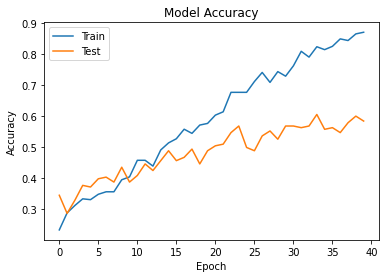

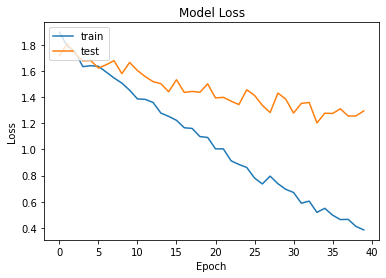

In [23]:

# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('Initial_Model_Accuracy.png')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Initial_Model_loss.png')
plt.show()

In [19]:
import tensorflow.keras as keras

# FIT MODEL AND USE CHECKPOINT TO SAVE BEST MODEL - THe graphs below as based on the continuing running thr above model 
# as it was saved off. 
checkpoint = ModelCheckpoint("best_initial_model.hdf5", monitor='val_accuracy', verbose=1,
    save_best_only=True, mode='max', period=1, save_weights_only=True)

model_history2=model.fit(X_train, y_train,batch_size=32, epochs=40, validation_split=0.2,callbacks=[checkpoint])


Epoch 1/40
24/24 [==============================] - 8s 334ms/step - loss: 0.3597 - accuracy: 0.8864 - precision: 0.9141 - recall: 0.8396 - val_loss: 1.3027 - val_accuracy: 0.6117 - val_precision: 0.6913 - val_recall: 0.5479

Epoch 00001: val_accuracy improved from -inf to 0.61170, saving model to best_initial_model.hdf5
Epoch 2/40
24/24 [==============================] - 8s 349ms/step - loss: 0.2807 - accuracy: 0.9211 - precision: 0.9512 - recall: 0.8864 - val_loss: 1.2600 - val_accuracy: 0.5957 - val_precision: 0.6712 - val_recall: 0.5213

Epoch 00002: val_accuracy did not improve from 0.61170
Epoch 3/40
24/24 [==============================] - 8s 327ms/step - loss: 0.2394 - accuracy: 0.9332 - precision: 0.9581 - recall: 0.8864 - val_loss: 1.2922 - val_accuracy: 0.6064 - val_precision: 0.6735 - val_recall: 0.5266

Epoch 00003: val_accuracy did not improve from 0.61170
Epoch 4/40
24/24 [==============================] - 8s 338ms/step - loss: 0.2410 - accuracy: 0.9345 - precision: 0.950

24/24 [==============================] - 8s 329ms/step - loss: 0.1110 - accuracy: 0.9679 - precision: 0.9796 - recall: 0.9626 - val_loss: 1.3183 - val_accuracy: 0.6436 - val_precision: 0.6933 - val_recall: 0.6011

Epoch 00029: val_accuracy did not improve from 0.64894
Epoch 30/40
24/24 [==============================] - 8s 337ms/step - loss: 0.1072 - accuracy: 0.9666 - precision: 0.9728 - recall: 0.9572 - val_loss: 1.3862 - val_accuracy: 0.6223 - val_precision: 0.6667 - val_recall: 0.5745

Epoch 00030: val_accuracy did not improve from 0.64894
Epoch 31/40
24/24 [==============================] - 8s 337ms/step - loss: 0.1107 - accuracy: 0.9652 - precision: 0.9756 - recall: 0.9639 - val_loss: 1.4581 - val_accuracy: 0.6117 - val_precision: 0.6543 - val_recall: 0.5638

Epoch 00031: val_accuracy did not improve from 0.64894
Epoch 32/40
24/24 [==============================] - 8s 335ms/step - loss: 0.1206 - accuracy: 0.9639 - precision: 0.9728 - recall: 0.9559 - val_loss: 1.3812 - val_accura

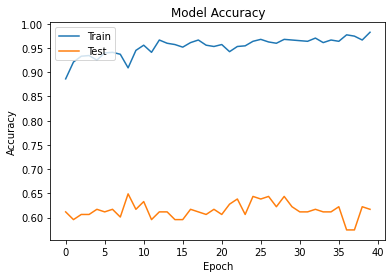

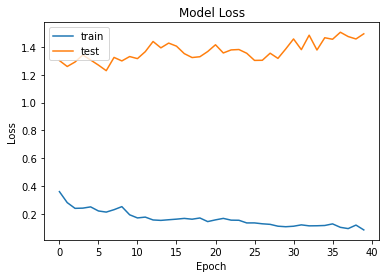

In [25]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
plt.plot(model_history2.history['accuracy'])
plt.plot(model_history2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('Initial_Model_Accuracy.png')
plt.show()
# summarize history for loss
plt.plot(model_history2.history['loss'])
plt.plot(model_history2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Initial_Model_loss.png')
plt.show()

## Post-Model Analysis

In [26]:
# PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

10/10 [==============================] - 1s 64ms/step - loss: 1.3587 - accuracy: 0.5865 - precision: 0.6287 - recall: 0.5481
Loss of the model is -  1.3587173223495483
10/10 [==============================] - 1s 63ms/step - loss: 1.3587 - accuracy: 0.5865 - precision: 0.6287 - recall: 0.5481
Accuracy of the model is -  58.65384340286255 %


In [46]:
from sklearn.preprocessing import LabelBinarizer

# PREDICTIONS
predictions = model.predict(X_test)
predictions=predictions.argmax(axis=1)
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

# ACTUAL LABELS
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'Actual Values': actual})

# COMBINE BOTH 
finaldf = actual.join(predictions)
#finaldf[130:150]

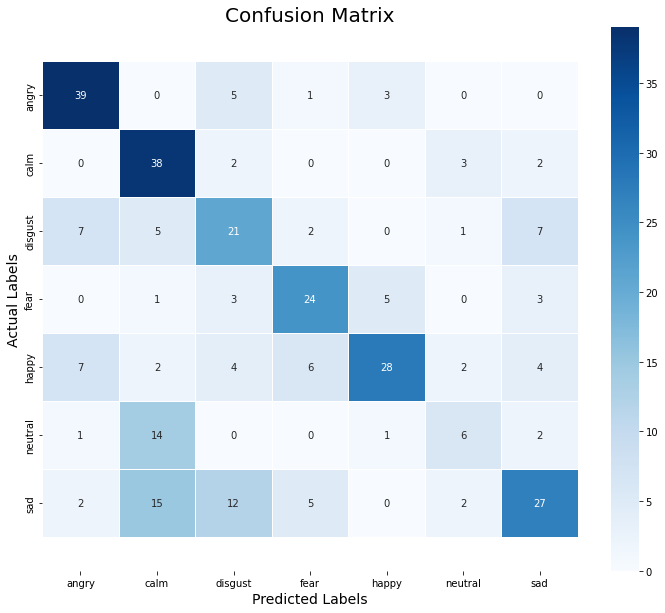

In [47]:
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION 
cm = confusion_matrix(actual, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('Initial_Model_Confusion_Matrix.png')
plt.show()

In [ ]:
print(classification_report(actual, predictions, target_names = ['angry','calm','disgust','fear','happy','neutral','sad']))

## Hyperparameter Tuning

In [ ]:
# TRAIN TEST SPLIT DATA
train,test = train_test_split(df_combined, test_size=0.2, random_state=0,
                               stratify=df_combined[['gender','actor']])

In [ ]:
y_train.shape

In [ ]:
X_train.shape 

In [ ]:
from tensorflow.keras.utils import to_categorical
lb = LabelEncoder()

y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

In [33]:

# CREATE FUNCTION FOR KERAS CLASSIFIER
opt = keras.optimizers.Adam(lr=0.0001)
def make_classifier(optimizer=opt):
    
    output_shape = y_train.shape[1]
    es = callbacks.EarlyStopping(patience=30, restore_best_weights=True)

    #BUILD CNN MODEL
    model = Sequential()
    model.add(layers.Conv2D(32, kernel_size=(4,10), activation='relu', input_shape=X_train[1].shape,padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.2)) # 1st

    model.add(layers.Conv2D(32, kernel_size=(4,10), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.2)) # 2nd

    model.add(layers.Conv2D(32, kernel_size=(4,10), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.2)) # 3rd 

    model.add(layers.Conv2D(32, kernel_size=(4,10)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D())
    model.add(layers.Dropout(0.2)) # 4rd 


    model.add(layers.Flatten())
    model.add(layers.Dense(64))
    model.add(layers.Dropout(0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.2))

    model.add(layers.Dense(output_shape, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy','Precision', 'Recall'])
    return model


In [34]:
# GRID SEARCH PARAMETERS TO FIND BEST VALUES
classifier = KerasClassifier(build_fn = make_classifier)
params = {
    'batch_size': [30, 32, 34],
    'nb_epoch': [20, 75, 20],
    'optimizer':['adam','SGD']}

grid_search = GridSearchCV(estimator=classifier,
                           param_grid=params,
                           scoring='accuracy',
                           cv=5)

grid_search = grid_search.fit(X_train,y_train)

23/23 [==============================] - 9s 338ms/step - loss: 2.2459 - accuracy: 0.1802 - precision: 0.2273 - recall: 0.0467


32/32 [==============================] - 11s 311ms/step - loss: 2.0351 - accuracy: 0.2447 - precision: 0.3526 - recall: 0.0588


In [36]:
grid_search.best_params_

{'batch_size': 30, 'nb_epoch': 20, 'optimizer': 'adam'}

In [37]:
grid_search.best_score_

nan

In [ ]:
# !pyenv virtualenvs

# Record voice from Mic

In [ ]:
# !pip install sounddevice 

In [ ]:
from scipy.io.wavfile import write
import sounddevice as sd

In [ ]:
sd.query_devices()

In [ ]:

from scipy.io.wavfile import write
import sounddevice as sd
sd.query_devices(4,'input')
fs = 44100  # Sample rate
seconds = 3  # Duration of recording

myrecording = sd.rec(int(seconds * fs), samplerate=fs, channels=1)
sd.wait()  # Wait until recording is finished



In [ ]:
write('pankajoutput.wav', fs, myrecording)  # Save as WAV file 

In [ ]:
!ls
